In [1]:
!git clone https://github.com/leslie-huang/UN-named-entity-recognition

Cloning into 'UN-named-entity-recognition'...
remote: Enumerating objects: 21580, done.
remote: Total 21580 (delta 0), reused 0 (delta 0), pack-reused 21580
Receiving objects: 100% (21580/21580), 14.70 MiB | 12.96 MiB/s, done.
Resolving deltas: 100% (21095/21095), done.


In [2]:
import torch 

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}.")

Using device cuda:0.


In [4]:
!pip install transformers
!pip install datasets
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.0 MB/s eta 0:00:

In [52]:
import math, random

split_fraction = 30
text = 'full_train.txt'
with open(text, 'r') as f:
  t = f.read()
t_split = t.split('\n\n')
random.shuffle(t_split)
middle = math.floor(len(t_split) / split_fraction)
t_split = t_split[:middle]
with open('Greek-data/Train/train.txt', 'w') as f:
  for sentence in t_split:
    f.write("{}\n\n".format(sentence))


In [53]:
import os
import itertools
import pandas as pd
import numpy as np
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch
label_list = ['O','B-PER','I-PER','B-ORG','I-ORG','B-LOC','I-LOC']
label_encoding_dict = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}

task = "ner" 
model_checkpoint = "nlpaueb/bert-base-greek-uncased-v1"
batch_size = 16

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# def get_all_tokens_and_ner_tags(directory):
    # return pd.concat([get_tokens_and_ner_tags(os.path.join(directory, filename)) for filename in os.listdir(directory)]).reset_index().drop('index', axis=1)
    
def get_all_tokens_and_ner_tags(directory):
    filenames = [filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))]
    return pd.concat([get_tokens_and_ner_tags(os.path.join(directory, filename)) for filename in filenames]).reset_index().drop('index', axis=1)

def get_tokens_and_ner_tags(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        split_list = [list(y) for x, y in itertools.groupby(lines, lambda z: z == '\n') if not x]
        tokens = [[x.split('\t')[0] for x in y] for y in split_list]
        entities = [[x.split('\t')[1][:-1] for x in y] for y in split_list] 
    return pd.DataFrame({'tokens': tokens, 'ner_tags': entities})
  
def get_un_token_dataset(train_directory, test_directory):
    train_df = get_all_tokens_and_ner_tags(train_directory)
    test_df = get_all_tokens_and_ner_tags(test_directory)
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    return (train_dataset, test_dataset)

train_dataset, test_dataset = get_un_token_dataset('./Greek-data/Train/', './Greek-data/Test/')


In [54]:
train_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 100
})

In [55]:
def tokenize_and_align_labels(examples):
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["tokens"]), truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif label[word_idx] == '0':
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(label_encoding_dict[label[word_idx]])
            else:
                label_ids.append(label_encoding_dict[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


train_tokenized_datasets = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/689 [00:00<?, ? examples/s]

In [56]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list)).to(device)

args = TrainingArguments(
    f"test-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=1e-5
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    
    with open("true_predictions.txt", 'w') as f:
         for pred in true_predictions:
            f.write("\t".join(pred) + "\n")
    
    with open("true_labels.txt", 'w') as f:
         for pred in true_labels:
            f.write("\t".join(pred) + "\n")

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}
    
trainer = Trainer(
    model,
    args,
    train_dataset=train_tokenized_datasets,
    eval_dataset=test_tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()
trainer.save_model('un-ner.model')

Some weights of the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not ini

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.323013,0.000000,0.000000,0.000000,0.924485
2,No log,0.198470,0.425562,0.271993,0.331873,0.941439
3,No log,0.169004,0.513690,0.353680,0.418926,0.950751


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
tokenizer = AutoTokenizer.from_pretrained('./un-ner.model/')

paragraph = 'Ο Αλέξιος είναι άπο την Ελλάδα και δουλεύει στην Θεσσαλονίκη για την εταιρεία ACME'
tokens = tokenizer(paragraph)
torch.tensor(tokens['input_ids']).unsqueeze(0).size()

model = AutoModelForTokenClassification.from_pretrained('./un-ner.model/', num_labels=len(label_list))
predictions = model.forward(input_ids=torch.tensor(tokens['input_ids']).unsqueeze(0), attention_mask=torch.tensor(tokens['attention_mask']).unsqueeze(0))
predictions = torch.argmax(predictions.logits.squeeze(), axis=1)
predictions = [label_list[i] for i in predictions]

words = tokenizer.batch_decode(tokens['input_ids'])
pd.DataFrame({'ner': predictions, 'words': words}).to_csv('un_ner.csv')

In [57]:
with open("true_predictions.txt", 'r') as f:
        lines = f.readlines()
        y_pred = []
        for line in lines:
          line = line[:-1]
          y_pred.append(line.split('\t'))

with open("true_labels.txt", 'r') as f:
      lines = f.readlines()
      y_true = []
      for line in lines:
        line = line[:-1]
        y_true.append(line.split('\t'))

In [58]:
from seqeval.metrics import classification_report as classification_report_seqeval

print(classification_report_seqeval(y_true, y_pred))

              precision    recall  f1-score   support

         LOC       0.61      0.47      0.53       661
         ORG       0.60      0.04      0.07       171
         PER       0.32      0.28      0.30       282

   micro avg       0.51      0.35      0.42      1114
   macro avg       0.51      0.26      0.30      1114
weighted avg       0.53      0.35      0.40      1114



In [132]:
data_size = np.array([100, 200, 375, 400, 600, 750, 1000, 1500, 2000, 3000])
metric = np.array([0.40,0.65, 0.70, 0.71, 0.74, 0.83, 0.85, 0.85, 0.87, 0.87])

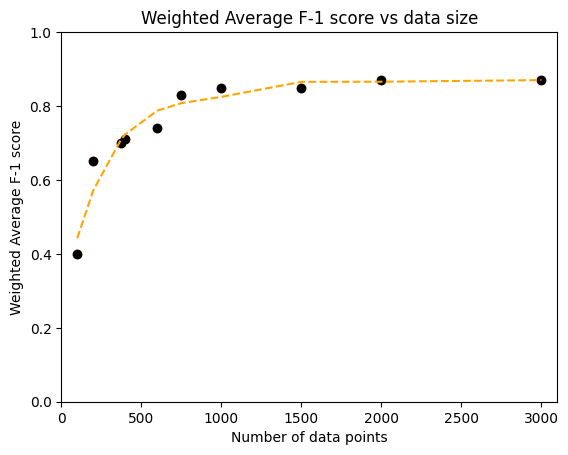

In [158]:


# fit a trend line
z = np.polyfit(data_size, metric, 1)
p = np.poly1d(z)



# Plot the scatter plot and logarithmic line of best fit
plt.scatter(data_size, metric, c = "lightsalmon")
# plot the trend line
# plt.plot(data_size, metric, "r--", c = 'orange')


z = np.polyfit(data_size, metric, 5)
f = np.poly1d(z)

# Create plot
plt.plot(data_size, metric, 'o', label='Original Data', c = "black")
plt.plot(data_size, f(data_size), label='Fit', linestyle='dashed', c = 'orange')

# set labels and title
plt.xlabel("Number of data points", )
plt.ylabel("Weighted Average F-1 score")
plt.title("")
plt.xlim([0,3100])
plt.ylim([0,1])
plt.title("W")
# show the plot
plt.show()

In [59]:
data_size = np.array([100, 200, 375, 400, 600, 750, 1000, 1500, 2000, 3000])
loc = np.array([0.53,0.73,0.73,0.76,0.81,0.86,0.85,0.87,0.88,0.91])
org = np.array([0.07,0.26,0.40,0.41,0.38,0.61,0.58,0.70,0.70,0.72])
per = np.array([0.30,0.71,0.71,0.76,0.78,0.88,0.86,0.88,0.88,0.88])

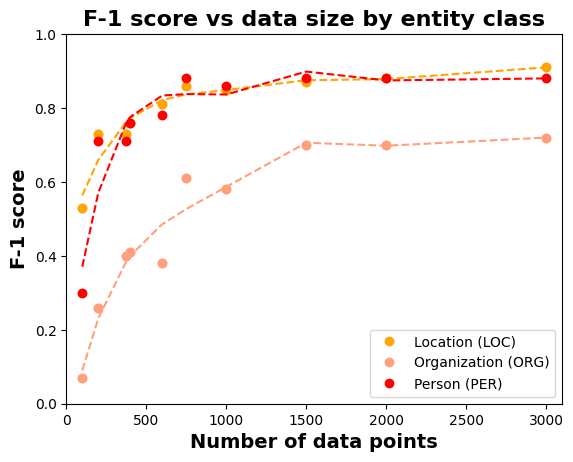

In [72]:
# fit a trend line
z_1 = np.polyfit(data_size, loc, 1)
p = np.poly1d(z_1)

# Plot the scatter plot and logarithmic line of best fit
plt.scatter(data_size, loc, c = "lightsalmon")



z_1 = np.polyfit(data_size, loc, 5)
f = np.poly1d(z_1)

# Create plot
plt.plot(data_size, loc, 'o', label='Location (LOC)', c = "orange")
plt.plot(data_size, f(data_size), linestyle='dashed', c = 'orange')


z_2 = np.polyfit(data_size, org, 1)
p = np.poly1d(z_2)

# Plot the scatter plot and logarithmic line of best fit
plt.scatter(data_size, org, c = "lightsalmon")



z_2 = np.polyfit(data_size, org, 5)
f = np.poly1d(z_2)

# Create plot
plt.plot(data_size, org, 'o', label='Organization (ORG)', c = "lightsalmon")
plt.plot(data_size, f(data_size), linestyle='dashed', c = 'lightsalmon')


z_3 = np.polyfit(data_size, per, 1)
p = np.poly1d(z_3)

# Plot the scatter plot and logarithmic line of best fit
plt.scatter(data_size, per, c = "lightsalmon")



z_3 = np.polyfit(data_size, per, 5)
f = np.poly1d(z_3)

# Create plot
plt.plot(data_size, per, 'o', label='Person (PER)', c = "red")
plt.plot(data_size, f(data_size), linestyle='dashed', c = 'red')

# set labels and title
plt.xlabel("Number of data points", fontsize=14, fontweight='bold')
plt.ylabel("F-1 score", fontsize=14, fontweight='bold')
plt.title("F-1 score vs data size by entity class", fontsize=16, fontweight='bold')
plt.xlim([0,3100])
plt.ylim([0,1])
plt.legend()
# show the plot
plt.show()